In [1]:
import networkx as nx
import numpy as np
import pandas as pd

G = nx.from_pandas_edgelist(pd.read_csv("data/Berlin-Tiergarten/berlin-tiergarten_net.tntp", sep="\t", skiprows=8), 
                            source="init_node", target="term_node")
line_G = nx.line_graph(G.to_undirected())

## Error Minimization

Baseline from http://hanj.cs.illinois.edu/pdf/icdm12_qgu.pdf

In [2]:
def choose_errormin_sensors(G, ratio):
    line_G = nx.line_graph(G.to_undirected())
    n = line_G.number_of_nodes()
    mu = 0.01

    L = nx.normalized_laplacian_matrix(line_G).toarray()
    eigenvalues, U = np.linalg.eigh(L)
    Lambda_inv = np.diag([1 / lam for lam in eigenvalues])

    Gamma = np.zeros((n, n))
    for i in range(n):
        if i > 1: 
            Gamma[i][i] = 1 / ((mu * eigenvalues[i] + 1) ** 2 - 1) ** 2
        else:
            Gamma[i][i] = 1 / ((mu * 1e-6 + 1) ** 2 - 1) ** 2
            
    l = int(G.number_of_nodes() * ratio)
    sensors = []
    H_inv = Gamma

    for k in range(l):
        idx, s, opt = None, None, -1 * float("inf")
        for i, e in enumerate(line_G.nodes()):
            if e not in sensors:
                u_e = U[i].transpose().reshape(U.shape[0], 1)
                val = (u_e.transpose() @ H_inv @ Lambda_inv @ H_inv @ u_e) / (1 + u_e.transpose() @ H_inv @ u_e)
                if val > opt:
                    idx, s, opt = i, e, val

        sensors.append(s)
        u_s = U[idx].transpose().reshape(U.shape[0], 1)    
        H_inv = H_inv - (H_inv @ u_s @ u_s.transpose() @ H_inv) / (1 + u_s.transpose() @ H_inv @ u_s)
        
    return sensors

In [3]:
def synthetic_signal(G):
    line_G = nx.line_graph(G.to_undirected())
    eigenvalues, eigenvectors = np.linalg.eigh(nx.normalized_laplacian_matrix(line_G).toarray())
    return dict(zip(line_G.nodes(), sum(1 / eigenvalues[i] * eigenvectors[:, i] for i in range(1, G.number_of_edges()))))

In [4]:
import scipy
import scipy.sparse.linalg as linalg

def speed_prediction(G, labelled_flows, lamb=1e-6, x0=None):
    '''
        Speed prediction.
    '''
    n_labelled_edges = len(labelled_flows)
    
    line_G = nx.line_graph(G.to_undirected())
    A = nx.adjacency_matrix(line_G)
    f0 = []
    
    A.data = A.data / np.repeat(np.add.reduceat(A.data, A.indptr[:-1]), np.diff(A.indptr))
   
    U = []
    L = []
    i = 0
    j = 0
    index = {}
    for e in line_G.nodes():
        if e in labelled_flows:
            f0.append(labelled_flows[e])
            L.append(i)
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    PUL = A[np.ix_(U, L)]
    f0 = np.array(f0)
    b = PUL.dot(f0)
    PUU = A[np.ix_(U, U)]
    A = scipy.sparse.identity(PUU.shape[0])-PUU   
    res = linalg.lsmr(A, b, damp=lamb, x0=x0)
    x = res[0]
    
    pred_flows = {}

    for e in line_G.nodes:
        if e in labelled_flows:
            pred_flows[e] = labelled_flows[e]
        else:
            pred_flows[e] = x[index[e]]
            
    return pred_flows

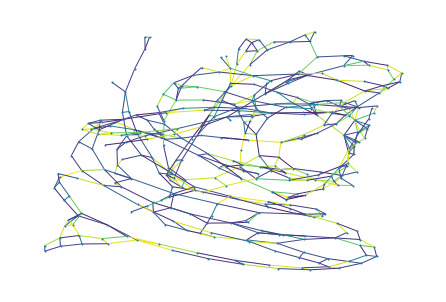

In [5]:
sensors = choose_errormin_sensors(G, 0.1)
signal = synthetic_signal(G)
pred = speed_prediction(G, {s: signal[s] for s in sensors})
pos = nx.spring_layout(G)
nx.draw(G, pos=pos, node_size=1, edge_color=[pred[e] for e in line_G.nodes()])

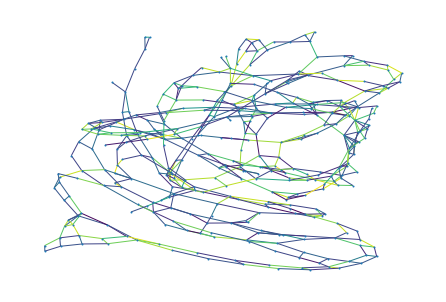

In [6]:
nx.draw(G, pos=pos, node_size=1, edge_color=[signal[e] for e in line_G.nodes()])

In [7]:
np.corrcoef(np.array(list(pred.values())), np.array(list(signal.values())))

array([[1.        , 0.98598889],
       [0.98598889, 1.        ]])

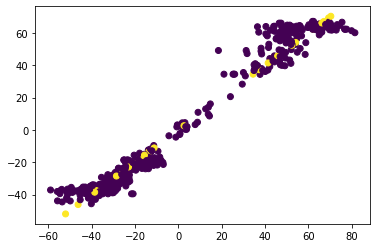

In [8]:
import matplotlib.pyplot as plt

plt.scatter(list(signal.values()), list(pred.values()), c = [1 if e in sensors else 0 for e in signal])

## Sampling

In [10]:
def choose_sampling_sensors(G, ratio, param=4):
    line_G = nx.line_graph(G.to_undirected())
    m = line_G.number_of_nodes()
    mapping = dict(zip(line_G.nodes(), range(m)))
    reverse = dict(zip(range(m), line_G.nodes()))
    nx.relabel_nodes(line_G, mapping, copy=False)
    
    L_k = np.linalg.matrix_power(nx.normalized_laplacian_matrix(line_G).toarray(), param)
        
    S = []
    
    for i in range(int(m * ratio)):
        S_complement = list(set(line_G.nodes()) - set(S))
        eigenvalues, eigenvectors = np.linalg.eigh(L_k[np.ix_(S_complement, S_complement)])
        
        opt = np.argmax(eigenvectors[:, 0].transpose() * eigenvectors[:, 0])
        
        S.append(S_complement[opt])    
             
    return [reverse[s] for s in S]

sensors = choose_sampling_sensors(G, .1, 4)

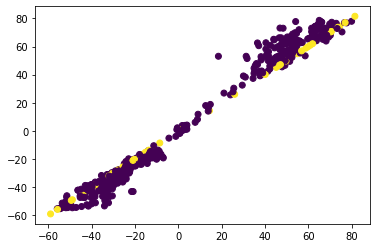

In [11]:
pred = speed_prediction(G, {s: signal[s] for s in sensors})
plt.scatter(list(signal.values()), list(pred.values()), c = [1 if e in sensors else 0 for e in signal])

In [12]:
np.corrcoef(np.array(list(pred.values())), np.array(list(signal.values())))

array([[1.        , 0.99198743],
       [0.99198743, 1.        ]])

## Proposed

In [13]:
import random
from scipy import sparse

def transition_matrix(G):
    A = np.array(nx.adjacency_matrix(G).todense())
    D_inv = np.diag([1 / x for x in np.sum(A, axis=0)])
    return np.dot(D_inv, A)

def weightedL2(a, b, w):
    q = a-b
    return (w*q*q).sum()

def choose_sensors_sparse(G, labeled_edges, weights, ratio=0.1, debug=False):
    k = int(G.number_of_edges() * ratio)
        
    m = G.number_of_edges()
    
    line_G = nx.line_graph(G)
    mapping = dict(zip(line_G.nodes(), range(m)))
    reverse = dict(zip(range(m), line_G.nodes()))
    nx.relabel_nodes(line_G, mapping, copy=False)
    x = np.array([labeled_edges[reverse[v]] for v in range(m)])
    w = np.array([weights[reverse[v]] for v in range(m)])
    
    # Choose random sensors
    C = [mapping[k] for k in labeled_edges]
    S = random.sample(C, k)
    T = sorted(list(set(C) - set(S)))
    
    # Initial prediction
    P = sparse.csc_matrix(transition_matrix(line_G))
    P_TT = P[np.ix_(T, T)]
    P_TS = P[np.ix_(T, S)]

    lu = sparse.linalg.splu(sparse.identity(m-k, format="csc") - P_TT)

    x_S = x[np.ix_(S)]
    x_T_hat = lu.solve(P_TS @ x_S)
    
    current_err = weightedL2(x_T_hat, x[np.ix_(T)], w[np.ix_(T)])
    old_err = float("inf")
    iteration = 0
    
    while old_err - current_err > 1e-5:
        old_err = current_err
        
        if debug:
            print("iteration {} current error {:e}".format(iteration, current_err))
        
        for i in range(k):
            # Move sensor i to a more optimal placement
#             subgraph = [v for v in line_G.neighbors(S[i])] 
#             nbrs = list(set(subgraph).intersection(set(C)).difference(set(S)))
            candidates = random.sample(list(set(C).difference(set(S))), min(10, len(C) - len(S)))
            
            for v in candidates:
                S_prime = S[:i] + [v] + S[i+1:]
                swap = np.where(np.array(T) == v)[0][0]
                T_prime = T[:swap] + [S[i]] + T[swap+1:]
                
                P_TT_prime = P[np.ix_(T_prime, T_prime)]
                
                P_TS_prime = P[np.ix_(T_prime, S_prime)]
                x_S_prime = x[np.ix_(S_prime)]
                
                U = np.zeros((m-k, 2))
                U[:, 1] = P_TT.toarray()[:, swap] - P_TT_prime.toarray()[:, swap]
                U[swap] = [1, 0]
                
                V = np.zeros((2, m-k))
                V[0] = P_TT.toarray()[swap] - P_TT_prime.toarray()[swap]
                V[:, swap] = [0, 1]
                
#                 if not np.allclose(P_TT - U @ V, P_TT_prime):
#                     print("Invalid rank 2 update:")
#                     print(P_TT - P_TT_prime)
#                     print(U @ V)
                
                x_int = lu.solve(P_TS_prime @ x_S_prime)
                Y = lu.solve(U)
                
                # the sparse version
                x_int = sparse.csc_array(x_int).transpose()
                Y = sparse.csc_matrix(Y)
                V = sparse.csc_matrix(V)
                x_T_prime_sparse = x_int - Y @ sparse.linalg.inv(sparse.identity(2, format="csc") + V @ Y) @ V @ x_int
                
#                 if not np.allclose(x_T_prime, x_T_prime_sparse.toarray()):
#                     print(x_T_prime)
#                     print(x_T_prime_sparse)
#                     print(x_T_prime - x_T_prime_sparse.toarray().transpose())
#                     return
                
                # If error decreased, keep the swap
                new_err = weightedL2(x_T_prime_sparse.transpose().toarray(), x[np.ix_(T_prime)], w[np.ix_(T_prime)])
                if new_err < current_err:
                    # New sensor and target sets
                    current_err = new_err
                    S = S_prime
                    T = T_prime
                    P_TT = P_TT_prime
                    
                    # Recompute LU decomposition
                    lu = sparse.linalg.splu(sparse.identity(m-k, format="csc") - P_TT)
                    # print(np.linalg.matrix_rank(np.identity(m-k) - P_TT))
                        
        if debug:
            print("end of iteration {} improvement {:e}".format(iteration, old_err - current_err))
        iteration += 1
    return [reverse[s] for s in S]

sensors = choose_sensors_sparse(G, signal, {e: 1 for e in G.edges()}, 0.1)

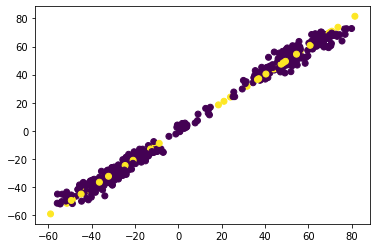

In [14]:
pred = speed_prediction(G, {s: signal[s] for s in sensors})
plt.scatter(list(signal.values()), list(pred.values()), c = [1 if e in sensors else 0 for e in signal])

In [15]:
np.corrcoef(np.array(list(pred.values())), np.array(list(signal.values())))

array([[1.        , 0.99603468],
       [0.99603468, 1.        ]])

## Experiments

In [23]:
from sensors import dict2vect

def err(G, sensors, labels, i, error):
    preds = speed_prediction(G, {s: labels[s] for s in sensors[:i]})
    return error(preds, labels)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def flow_weighted_corr(G, flows):
    return lambda preds, labels: corr(dict2vect(G, preds), dict2vect(G, labels), dict2vect(G, flows))

In [35]:
from tqdm.notebook import tqdm

def get_speed_results(G, flows, speeds, ratio, samples=10):
    fwcorr = flow_weighted_corr(G, flows)
    
    errormin_sensors = choose_errormin_sensors(G, ratio)
    sampling_sensors = choose_sampling_sensors(G, ratio)
    
    errormin_corr, sampling_corr, proposed_corr = {0: 0}, {0: 0}, {0: 0}
        
    for j in tqdm(range(1, samples + 1)):
        r = ratio * j / samples
        i = int(r * G.to_undirected().number_of_edges())
        
        proposed_sensors = choose_sensors_sparse(G, speeds, weights=flows, ratio=r)
        
        proposed_corr[r] = max(err(G, proposed_sensors, speeds, i, fwcorr), 0)
        sampling_corr[r] = max(err(G, sampling_sensors, speeds, i, fwcorr), 0)
        errormin_corr[r] = max(err(G, errormin_sensors, speeds, i, fwcorr), 0)
        
    return {
        "proposed": proposed_corr,
        "sampling": sampling_corr,
        "errormin": errormin_corr
    }

In [41]:
def read_tntp_graph(filename):
    edgelist = pd.read_csv(filename, sep="\t")
    G = nx.from_pandas_edgelist(edgelist, source="From ", target="To ", edge_attr="Volume ")
    flows = {(u,v) : d["Volume "] for u,v,d in G.edges(data=True)}
    speeds = synthetic_signal(G)
    return G, flows, speeds

In [42]:
Berlin = nx.from_pandas_edgelist(pd.read_csv("data/Berlin-Tiergarten/berlin-tiergarten_net.tntp", sep="\t", skiprows=8), 
                            source="init_node", target="term_node")
EMA = nx.from_pandas_edgelist(pd.read_csv("data/Eastern-Massachusetts/EMA_net.tntp", sep="\t", skiprows=8), 
                            source="init_node", target="term_node")
LA = nx.from_pandas_edgelist(pd.read_csv("out/small.results.csv"), source="edge_from", target="edge_to")

In [43]:
results["Anaheim"] = get_speed_results(*read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"), 0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [44]:
results["Berlin"] = get_speed_results(Berlin, {e: 1 for e in Berlin.edges()}, synthetic_signal(Berlin), 0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
results["EMA"] = get_speed_results(EMA, {e: 1 for e in EMA.edges()}, synthetic_signal(EMA), 0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
results["LA"] = get_speed_results(LA, {e: 1 for e in LA.edges()}, synthetic_signal(LA), 0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

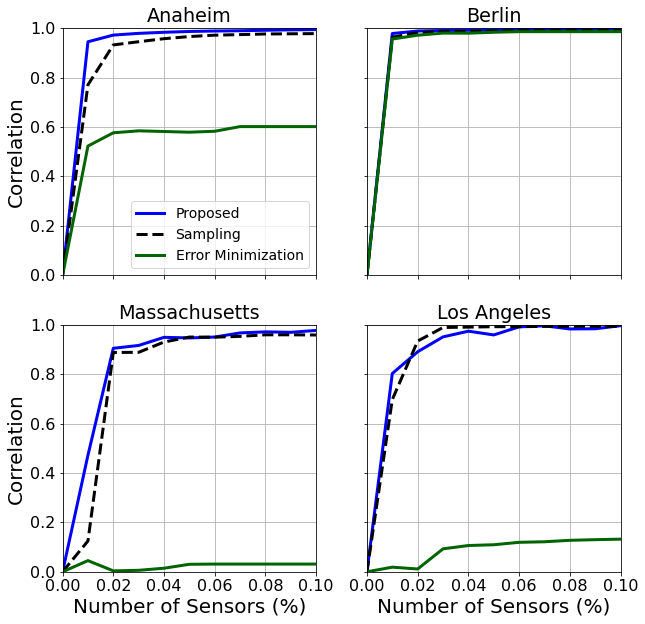

In [47]:
import matplotlib

def plot_speed_results(results, ax, title="", xlabel=False, ylabel=False, legend=False):
    ax.plot(results["proposed"].keys(), results["proposed"].values(), "b", label="Proposed",
           linewidth=3)
    ax.plot(results["sampling"].keys(), results["sampling"].values(), "black", label="Sampling",
           linewidth=3, linestyle="dashed")
    ax.plot(results["errormin"].keys(), results["errormin"].values(), "darkgreen", label="Error Minimization",
           linewidth=3)
    
    if legend:
        ax.legend(fontsize=14)
    ax.set_xlim(0, .1)
    ax.set_ylim(0, 1)
    if xlabel:
        ax.set_xlabel("Number of Sensors (%)", fontsize=20)
    else:
        ax.set_xticklabels([])
    if ylabel:
        ax.set_ylabel("Correlation", fontsize=20)
    else:
        ax.set_yticklabels([])
    ax.grid("on")
    ax.set_title(title)
    
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

plot_speed_results(results["Anaheim"], ax[0][0], title="Anaheim", ylabel=True, legend=True)
plot_speed_results(results["Berlin"], ax[0][1], title="Berlin")
plot_speed_results(results["EMA"], ax[1][0], title="Massachusetts", xlabel=True, ylabel=True)
plot_speed_results(results["LA"], ax[1][1], title="Los Angeles", xlabel=True)

# plt.savefig("results/synthetic_speeds.pdf")